In [1]:
import os, random, pickle
import numpy as np
import pandas as pd
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss
from nilearn import datasets, image, plotting
import matplotlib.pyplot as plt

/Users/ehbeam/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Evaluate top models in each class on the test set

_Models are logistic regression classifiers predicting whether or not an activation coordinate was reported within each structure of the Harvard-Oxford atlas based on psychological features in the article full text_

_Top models in each class were identified by a grid search over 200 random combinations of hyperparameters, including penalty, inverse regularization strength (c), intercept, and maximum number of iterations_ 

### Functions for classifier training and prediction

In [2]:
def train(classifier, activation_atlas, features, verbose=False):
    fits, count = {}, 0
    for structure in activation_atlas.columns:
        if verbose:
            clear_output()
            print("Fitting classifier {}/{}: {}".format(count+1, len(activation_atlas.columns), structure))
        classifier.fit(features, activation_atlas[structure])
        fits[structure] = pickle.dumps(classifier)
        count += 1
    if verbose:
        clear_output()
        print("Trained classifiers for {} brain structures".format(count))
    return fits

In [3]:
def mind2brain(fits, activation_atlas, features):
    predictions = {}
    for structure in activation_atlas.columns:
        fit = pickle.loads(fits[structure])
        predictions[structure] = fit.predict(features)
    return predictions

### Split studies into training and test sets

In [4]:
activation_atlas = pd.read_csv("data/activations_prob0.csv", index_col=0, header=0)

In [5]:
random.seed(42)
train_prop, val_prop = 0.7, 0.2
ids = sorted(list(activation_atlas.index))
random.shuffle(ids)
train_ids = ids[:int(train_prop*len(ids))]
test_ids = ids[int((train_prop+val_prop)*len(ids)):]

### Load hyperparameters of the top models

In [39]:
top_models = pd.read_csv("data/top_models_180613.csv", index_col=2, header=0)

In [40]:
top_models.head()

,INDEX,MODEL,ORGANIZATION,LABELS,COORD_PROB_THRES,ALPHA,BETA,TRAIN_PERPLEXITY,VAL_PERPLEXITY,PENALTY,C,INTERCEPT,MAX_ITER,TRAIN_MACRO_PRECISION,TRAIN_MICRO_PRECISION,TRAIN_MACRO_RECALL,TRAIN_MICRO_RECALL,TRAIN_MACRO_F1,TRAIN_MICRO_F1,TRAIN_LOGLOSS,VAL_MACRO_PRECISION,VAL_MICRO_PRECISION,VAL_MACRO_RECALL,VAL_MICRO_RECALL,VAL_MACRO_F1,VAL_MICRO_F1,VAL_LOGLOSS,EXTENSION
PARAMS,,,,,,,,,,,,,,,,,,,,,,,,,,,,
lda_2_0,2,LDA,NaN,NaN,0,6.840819,9.977279,36.651225,100.012069,l2,0.236161,True,58,0.466543,0.603004,0.278176,0.417583,0.237866,0.493450,487.156657,0.279011,0.574118,0.265309,0.402379,0.220134,0.473146,493.447370,csv
lda_64_25,64,LDA,NaN,NaN,25,0.432085,8.747171,25.509921,172.300861,l1,9.521568,True,155,0.350500,0.584090,0.071758,0.141134,0.094165,0.227337,321.347825,0.149719,0.437047,0.051557,0.107212,0.063263,0.172185,324.122993,csv
lda_197_50,197,LDA,NaN,NaN,50,0.304059,3.485022,24.412851,196.356641,l1,9.485622,True,105,0.144038,0.553638,0.017840,0.051289,0.028070,0.093880,89.559715,0.064100,0.364010,0.010720,0.033627,0.016138,0.061566,87.513895,csv
llda_cons_seeds_79_0,79,L-LDA,cons,seeds,0,9.713033,5.241644,65.357377,273.043966,l2,2.015075,False,191,0.534874,0.611778,0.349561,0.482878,0.349911,0.539739,439.782484,0.365056,0.539027,0.302639,0.431466,0.288620,0.479286,472.102977,csv
llda_cons_seeds_123_25,123,L-LDA,cons,seeds,25,7.383734,2.176274,58.942847,304.627694,l1,8.341523,False,100,0.372578,0.575611,0.080076,0.154029,0.105418,0.243026,319.819071,0.179108,0.430686,0.056414,0.115298,0.069854,0.181899,324.379836,csv


### Fit each top model on the test set

_The test set includes 1,094 articles withheld from training and hyperparameter optimization_

In [46]:
for model in top_models.index:
    clear_output()
    print("Fitting: {}".format(model))
    activation_atlas = pd.read_csv("data/activations_prob{}.csv".format(top_models.loc[model,"COORD_PROB_THRES"]), index_col=0, header=0)
    features = pd.read_csv("features/{}.{}".format("_".join(model.split("_")[:-1]), top_models.loc[model,"EXTENSION"]), index_col=0, header=0)
    classifier = LogisticRegression(penalty=top_models.loc[model,"PENALTY"],
                                C=top_models.loc[model,"C"], 
                                fit_intercept=top_models.loc[model,"INTERCEPT"],
                                max_iter=top_models.loc[model,"MAX_ITER"])
    fits = train(classifier, activation_atlas.loc[train_ids], features.loc[train_ids])
    pred = pd.DataFrame(mind2brain(fits, activation_atlas.loc[test_ids], features.loc[test_ids]))
    top_models.at[model,"TEST_MACRO_PRECISION"] = precision_score(activation_atlas.loc[test_ids], pred, average="macro")
    top_models.at[model,"TEST_MICRO_PRECISION"] = precision_score(activation_atlas.loc[test_ids], pred, average="micro")
    top_models.at[model,"TEST_MACRO_RECALL"] = recall_score(activation_atlas.loc[test_ids], pred, average="macro")
    top_models.at[model,"TEST_MICRO_RECALL"] = recall_score(activation_atlas.loc[test_ids], pred, average="micro")
    top_models.at[model,"TEST_MACRO_F1"] = f1_score(activation_atlas.loc[test_ids], pred, average="macro")
    top_models.at[model,"TEST_MICRO_F1"] = f1_score(activation_atlas.loc[test_ids], pred, average="micro")
    top_models.at[model,"TEST_LOGLOSS"] = log_loss(activation_atlas.loc[test_ids], pred)
clear_output()
print("Fitting on test set complete!".format(model))

Fitting: llda_cons_seeds_79_0


FileNotFoundError: File b'features/llda_cons_seeds_79.csv' does not exist

In [45]:
top_models["TEST_MICRO_F1"].sort_values(ascending=False)

PARAMS
lda_2_0                          0.491537
lda_64_25                        0.206952
lda_197_50                       0.081697
llda_cons_seeds_79_0                  NaN
llda_cons_seeds_123_25                NaN
llda_cons_seeds_59_50                 NaN
llda_cons_seeds_syns_40_0             NaN
llda_cons_seeds_syns_123_25           NaN
llda_cons_seeds_syns_88_50            NaN
llda_kmeans_seeds_67_0                NaN
llda_kmeans_seeds_122_25              NaN
llda_kmeans_seeds_174_50              NaN
llda_kmeans_seeds_syns_81_0           NaN
llda_kmeans_seeds_syns_165_25         NaN
llda_kmeans_seeds_syns_33_50          NaN
bags_cons_seeds_0                     NaN
bags_cons_seeds_25                    NaN
bags_cons_seeds_50                    NaN
bags_cons_seeds_syns_0                NaN
bags_cons_seeds_syns_25               NaN
bags_cons_seeds_syns_50               NaN
bags_kmeans_seeds_0                   NaN
bags_kmeans_seeds_25                  NaN
bags_kmeans_seeds_50       

In [10]:
top_models.to_csv("data/test_performance_180613.csv")

### Refit the classifier with the winning model

In [11]:
top_model = top_models["TEST_MICRO_F1"].sort_values(ascending=False).index[0]
top_model

'bags_cons_seeds_syns_0'

In [12]:
activation_atlas = pd.read_csv(
    "data/activations_prob{}.csv".format(top_models.loc[top_model,"COORD_PROB_THRES"]), 
    index_col=0, header=0)
features = pd.read_csv(
    "features/{}.csv".format("_".join(top_model.split("_")[:-1])), 
    index_col=0, header=0)

In [13]:
classifier = LogisticRegression(penalty=top_models.loc[top_model,"PENALTY"],
                                C=top_models.loc[top_model,"C"], 
                                fit_intercept=top_models.loc[top_model,"INTERCEPT"],
                                max_iter=top_models.loc[top_model,"MAX_ITER"])

In [14]:
fits = train(classifier, activation_atlas.loc[train_ids], features.loc[train_ids], verbose=True)

Trained classifiers for 56 brain structures


In [15]:
pred = pd.DataFrame(mind2brain(fits, activation_atlas.loc[test_ids], features.loc[test_ids]))

## 2. Visualize model coefficients on the brain and by structure

### Harvard-Oxford cortical and subcortical atlases

In [16]:
cor = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm').maps
sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm').maps

_Excuse the mess, but we need to make cortical and subcortical labels compatible_

In [17]:
sub_relab_map_r2l = {1:0, 2:0, 3:0, 12:0, 13:0, 14:0, 15:4, 16:5, 17:6, 18:7, 19:9, 20:10, 21:11}
sub_relab_map = {4:1, 5:2, 6:3, 7:4, 9:5, 10:6, 11:7}
sub_relab = image.load_img(sub).get_data()
for old, new in sub_relab_map_r2l.items():
    sub_relab[sub_relab == old] = new
for old, new in sub_relab_map.items():
    sub_relab[sub_relab == old] = new
sub_relab = sub_relab + 48
sub_relab[sub_relab == 48] = 0
cor_relab = image.load_img(cor).get_data()
relab = np.add(sub_relab, cor_relab)
relab[relab > 57] = 0
img = image.new_img_like(cor, relab)

### Matrix of model coefficients sorted by atlas labels

In [18]:
labels = pd.read_csv("data/harvard-oxford.csv", index_col=2, header=0)

In [19]:
coef = pd.DataFrame(index=activation_atlas.columns, columns=features.columns)
for structure in activation_atlas.columns:
    coef.loc[structure] = pickle.loads(fits[structure]).coef_

In [20]:
coef["ATLAS"] = labels.loc[coef.index, "INDEX"]
coef = coef.sort_values(["ATLAS"])

### Brain maps of coefficients for model features

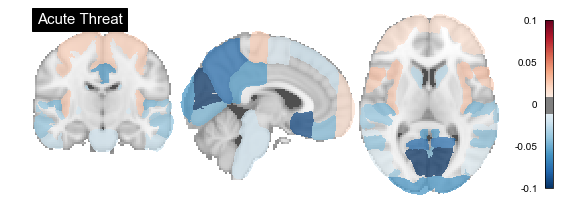

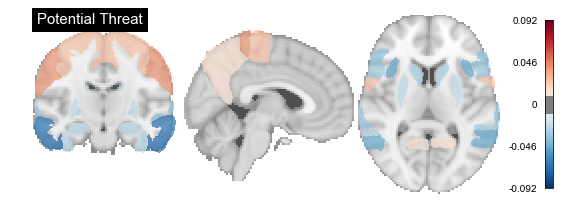

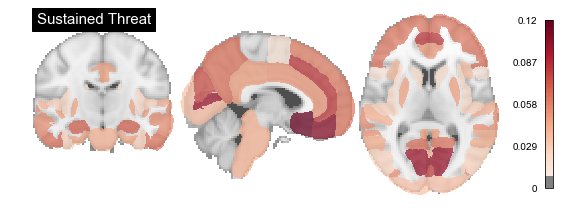

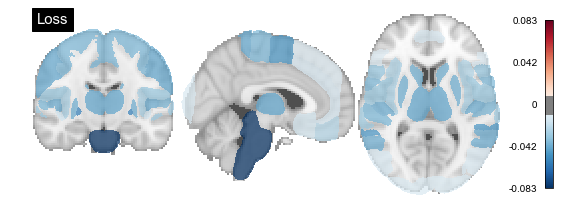

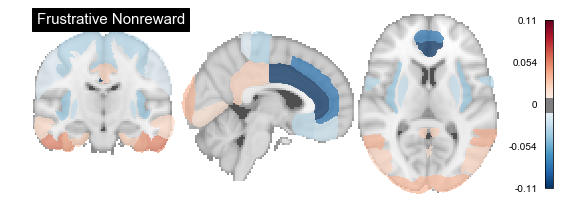

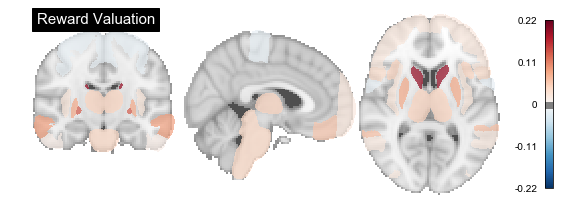

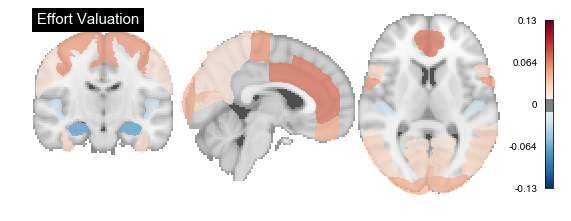

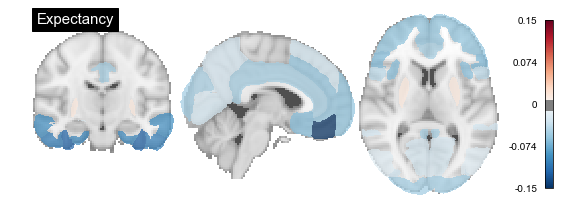

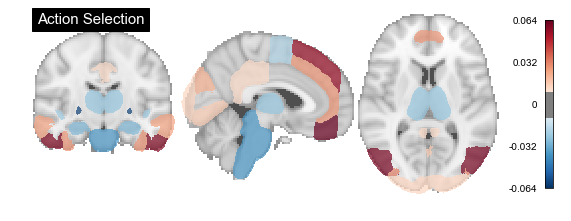

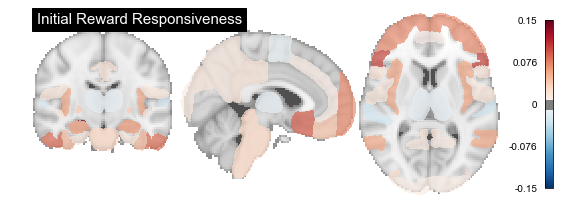

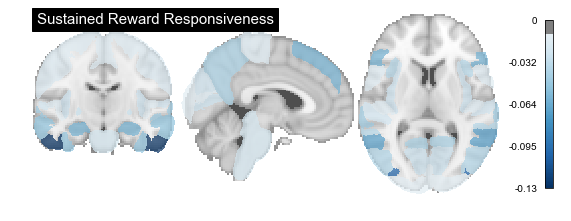

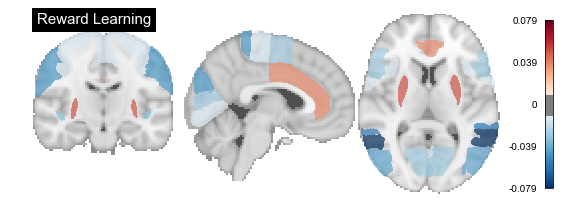

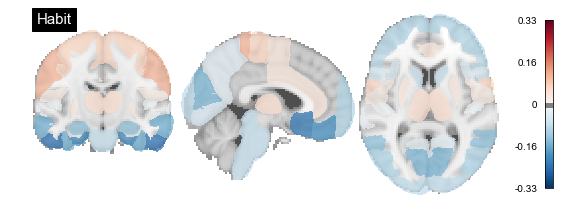

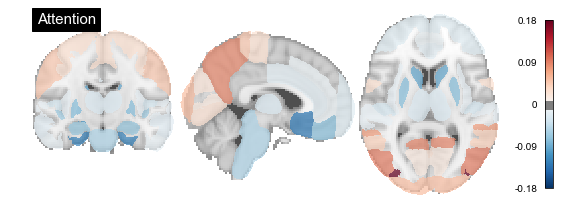

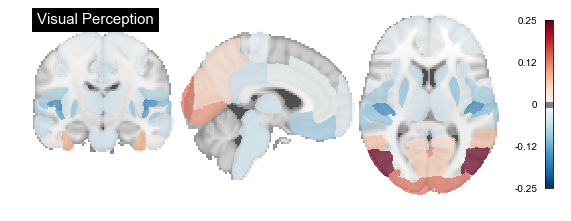

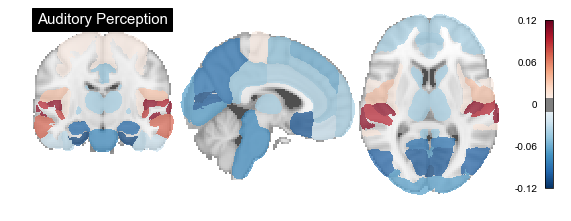

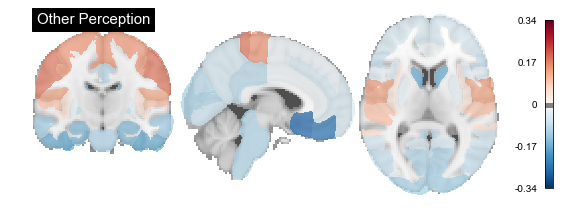

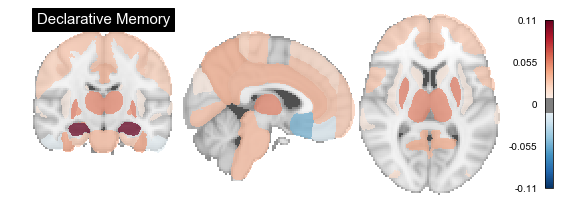

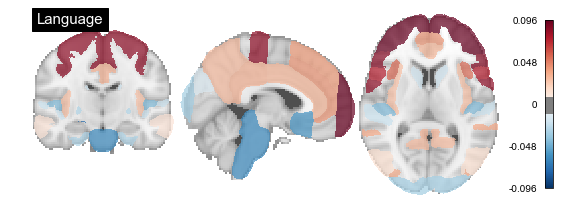

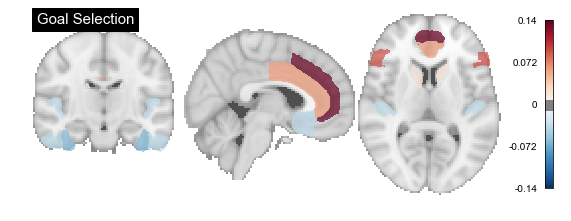

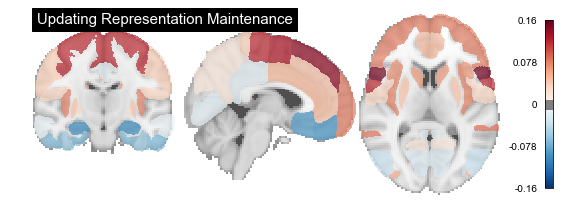

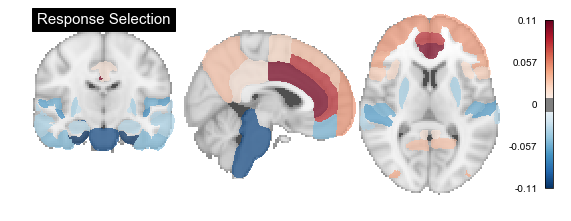

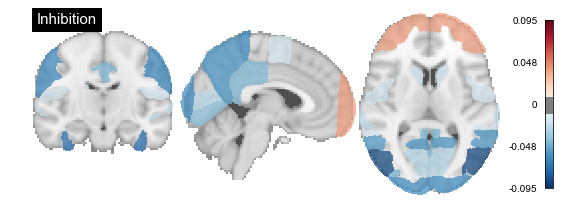

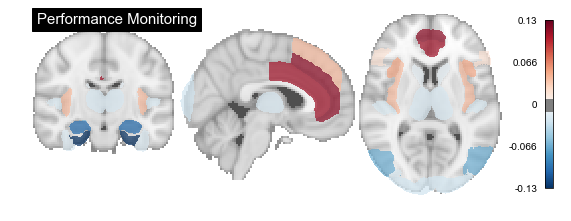

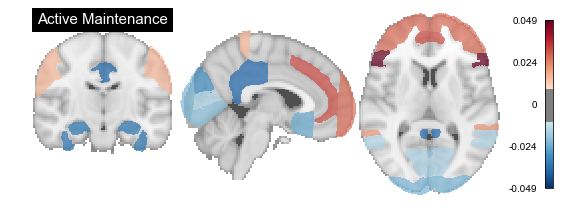

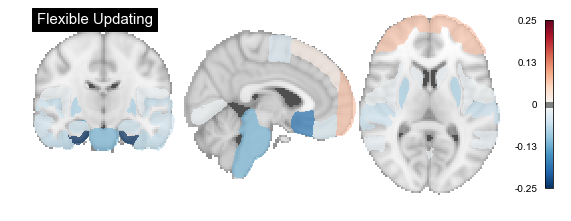

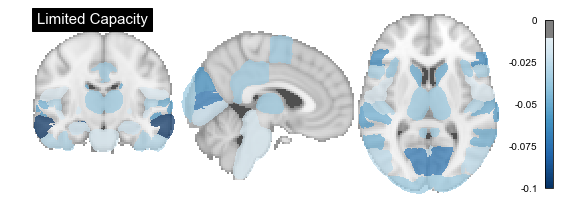

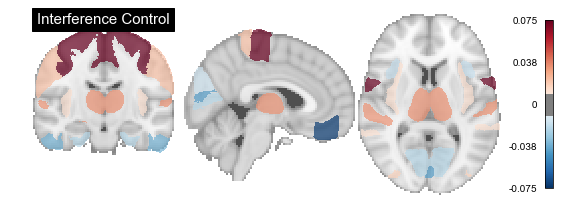

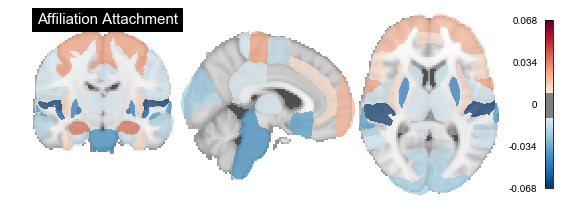

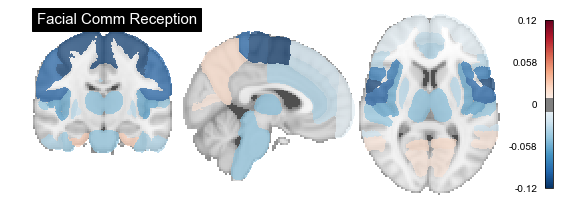

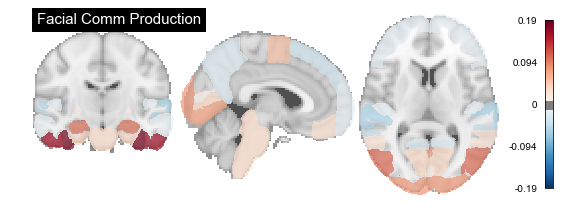

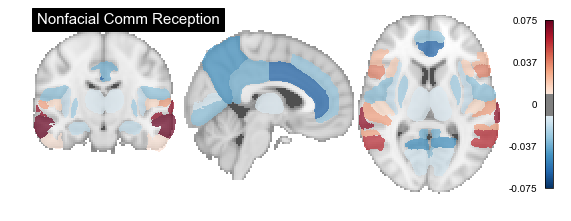

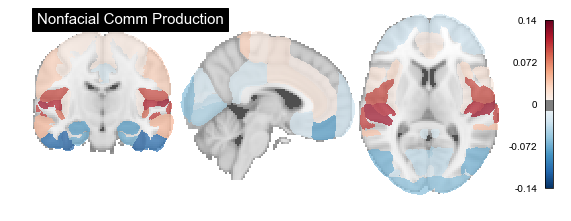

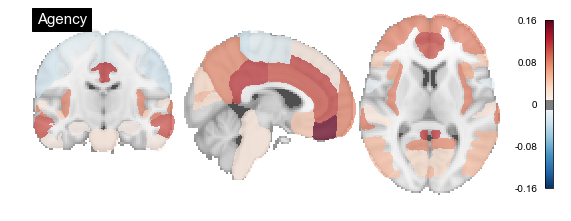

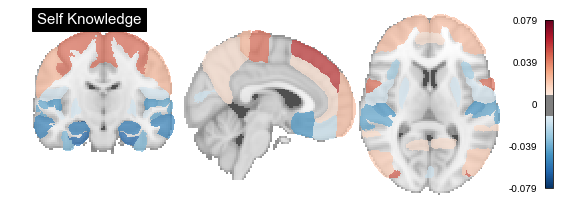

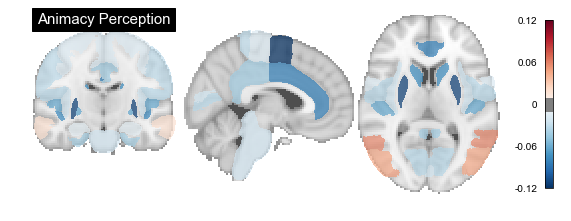

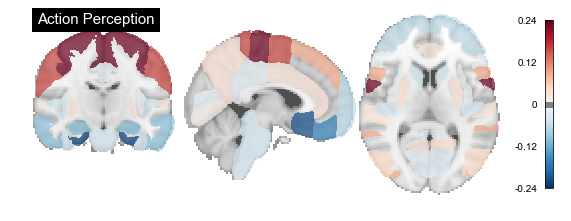

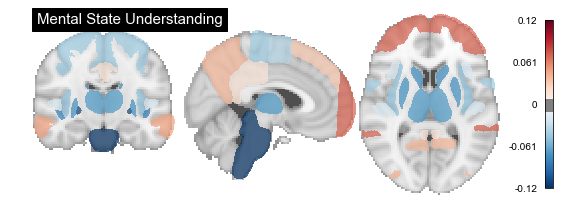

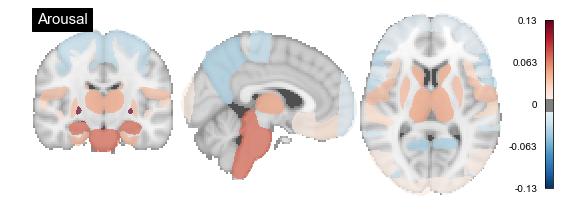

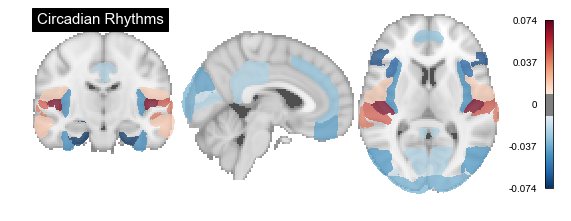

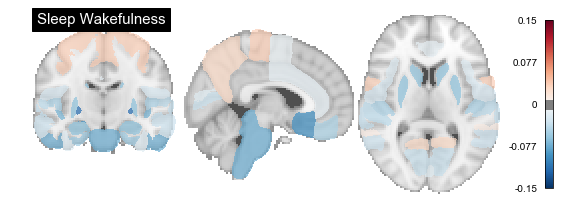

In [21]:
plt.rcParams["font.family"] = "Arial"
for feature in coef.columns[:-1]:
    feature_map = image.copy_img(img).get_data()
    for i, value in enumerate(coef[feature]):
        feature_map[feature_map == i+1] = value
    feature_map = image.new_img_like(img, feature_map)
    display = plotting.plot_stat_map(feature_map,
                                             cmap="RdBu_r",
                                             threshold=0.01,
                                             alpha=0.7,
                                             cut_coords=(4,-16,9),
                                             title=feature.replace("_", " ").title(),
                                             annotate=False,
                                             draw_cross=False)
    #display.savefig("figures/brainvis_{}.png".format(feature), dpi=250) 
    plotting.show()
    display.close()

In [22]:
len(test_ids)

1094

### Bar charts of the most predictive features for select structures

In [23]:
labels["PREPROCESSED"]=labels.index

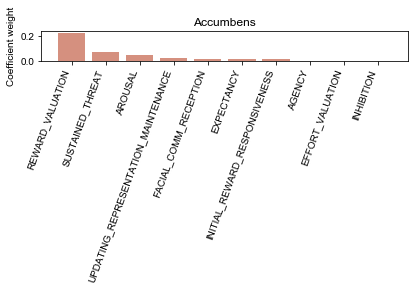

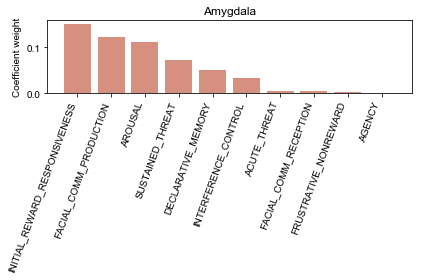

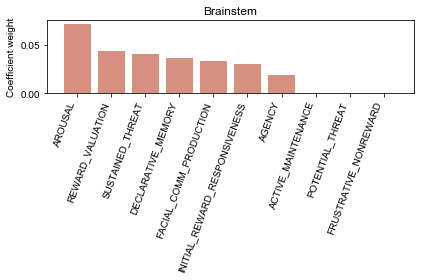

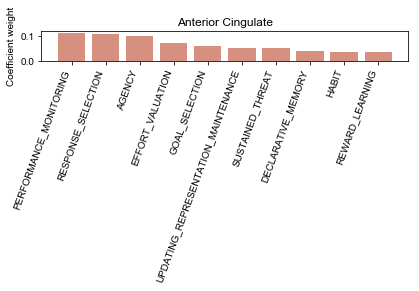

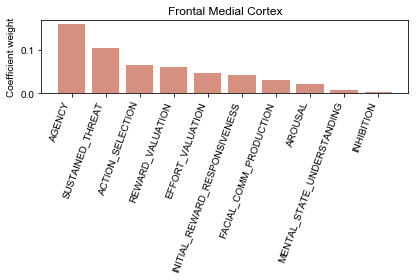

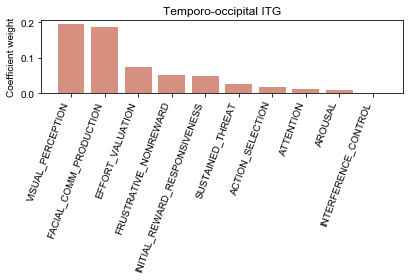

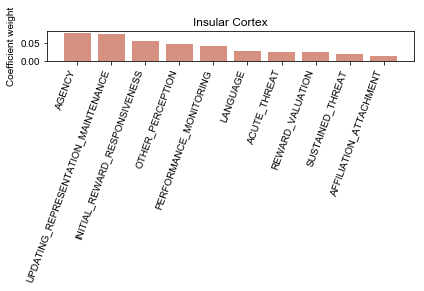

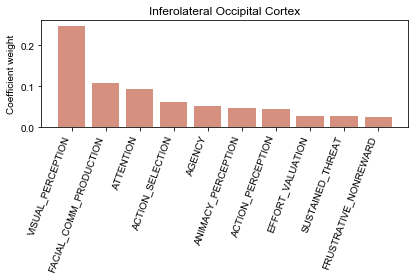

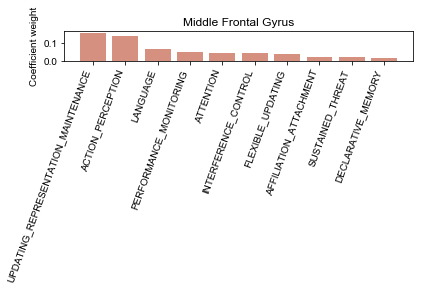

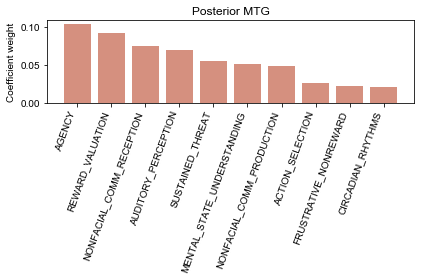

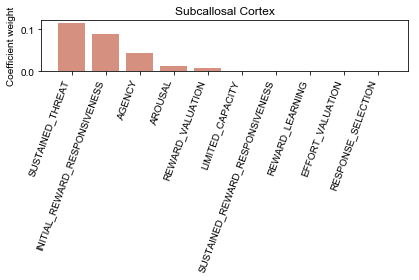

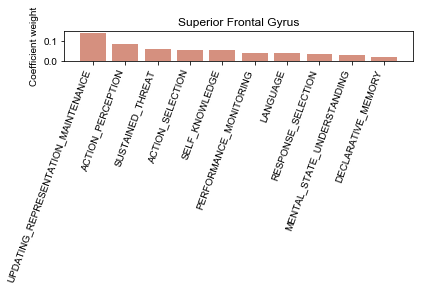

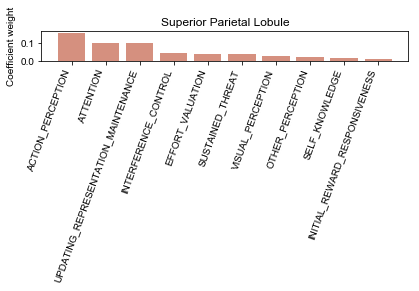

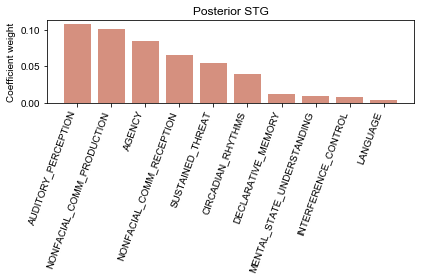

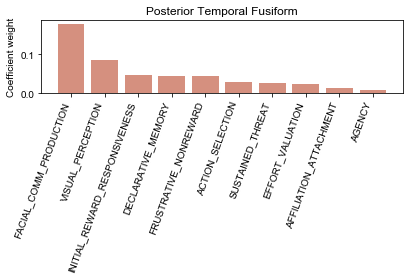

In [24]:
plt.rcParams["font.family"] = "Arial"
for structure in ["accumbens", "amygdala", "brainstem", "cingulate_gyrus_anterior_division", 
                  "frontal_medial_cortex", "inferior_temporal_gyrus_temporooccipital_part", 
                  "insular_cortex", "lateral_occipital_cortex_inferior_division", "middle_frontal_gyrus", 
                  "middle_temporal_gyrus_posterior_division", "subcallosal_cortex", "superior_frontal_gyrus", 
                  "superior_parietal_lobule", "superior_temporal_gyrus_posterior_division", 
                  "temporal_fusiform_cortex_posterior_division"]:
    top_features = coef.loc[structure].sort_values(ascending=False)[1:11]
    fig, ax = plt.subplots()
    ax.bar(range(10), top_features, align="center", alpha=0.85, color="#CE7D69")
    ax.set_xticks(range(10))
    ax.set_xticklabels(top_features.index, rotation=70, ha="right")
    ax.set_ylabel("Coefficient weight")
    ax.set_title(labels.loc[structure,"PRESENTABLE"])
    plt.tight_layout()
    fig.savefig("figures/topfeat_{}.png".format(structure), dpi=250) 
    plt.show()

## 3. Apply the model to a randomly selected study not seen in training

_Let's begin by picking out a random study from the test set_

In [25]:
random.seed(7)
PMID = random.sample(test_ids, 1)

### Model input and output

_Next, let's check out the text-based features for this article_

In [26]:
pd.set_option("display.max_columns", len(features.columns))
features.loc[PMID]

,ACUTE_THREAT,POTENTIAL_THREAT,SUSTAINED_THREAT,LOSS,FRUSTRATIVE_NONREWARD,REWARD_VALUATION,EFFORT_VALUATION,EXPECTANCY,ACTION_SELECTION,INITIAL_REWARD_RESPONSIVENESS,SUSTAINED_REWARD_RESPONSIVENESS,REWARD_LEARNING,HABIT,ATTENTION,VISUAL_PERCEPTION,AUDITORY_PERCEPTION,OTHER_PERCEPTION,DECLARATIVE_MEMORY,LANGUAGE,GOAL_SELECTION,UPDATING_REPRESENTATION_MAINTENANCE,RESPONSE_SELECTION,INHIBITION,PERFORMANCE_MONITORING,ACTIVE_MAINTENANCE,FLEXIBLE_UPDATING,LIMITED_CAPACITY,INTERFERENCE_CONTROL,AFFILIATION_ATTACHMENT,FACIAL_COMM_RECEPTION,FACIAL_COMM_PRODUCTION,NONFACIAL_COMM_RECEPTION,NONFACIAL_COMM_PRODUCTION,AGENCY,SELF_KNOWLEDGE,ANIMACY_PERCEPTION,ACTION_PERCEPTION,MENTAL_STATE_UNDERSTANDING,AROUSAL,CIRCADIAN_RHYTHMS,SLEEP_WAKEFULNESS
PMID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18639870,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,4,0,1,8,0,0,1,1,0,0,0,0,0,1,2,4,4,6,0,2,0,1,1,0,1,0


_Now let's compare predicted and actual brain activations_

In [27]:
pred = mind2brain(fits, activation_atlas.loc[PMID], features.loc[PMID])
pd.set_option("display.max_columns", len(activation_atlas.columns))
pred_vs_true = pd.DataFrame(pred).append(activation_atlas.loc[PMID])
pred_vs_true.index = ["PREDICTED", "TRUE"]
pred_vs_true

,accumbens,amygdala,angular_gyrus,brainstem,caudate,central_opercular_cortex,cingulate_gyrus_anterior_division,cingulate_gyrus_posterior_division,cuneal_cortex,frontal_medial_cortex,frontal_operculum_cortex,frontal_orbital_cortex,frontal_pole,heschls_gyrus,hippocampus,inferior_frontal_gyrus_pars_opercularis,inferior_frontal_gyrus_pars_triangularis,inferior_temporal_gyrus_anterior_division,inferior_temporal_gyrus_posterior_division,inferior_temporal_gyrus_temporooccipital_part,insular_cortex,intracalcarine_cortex,lateral_occipital_cortex_inferior_division,lateral_occipital_cortex_superior_division,lingual_gyrus,middle_frontal_gyrus,middle_temporal_gyrus_anterior_division,middle_temporal_gyrus_posterior_division,middle_temporal_gyrus_temporooccipital_part,occipital_fusiform_gyrus,occipital_pole,pallidum,paracingulate_gyrus,parahippocampal_gyrus_anterior_division,parahippocampal_gyrus_posterior_division,parietal_operculum_cortex,planum_polare,planum_temporale,postcentral_gyrus,precentral_gyrus,precuneous_cortex,putamen,subcallosal_cortex,superior_frontal_gyrus,superior_parietal_lobule,superior_temporal_gyrus_anterior_division,superior_temporal_gyrus_posterior_division,supplementary_motor_cortex,supracalcarine_cortex,supramarginal_gyrus_anterior_division,supramarginal_gyrus_posterior_division,temporal_fusiform_cortex_anterior_division,temporal_fusiform_cortex_posterior_division,temporal_occipital_fusiform_cortex,temporal_pole,thalamus
PREDICTED,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,1,1,0,0,1,0,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0
TRUE,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1


In [28]:
print("\nPerformance on a randomly selected article (PMID={})\n".format(PMID[0]))
print("PRECISION:\t {0:.3f}".format(precision_score(pred_vs_true.loc["TRUE"], pred_vs_true.loc["PREDICTED"])))
print("RECALL:\t\t {0:.3f}".format(recall_score(pred_vs_true.loc["TRUE"], pred_vs_true.loc["PREDICTED"])))
print("F1:\t\t {0:.3f}".format(f1_score(pred_vs_true.loc["TRUE"], pred_vs_true.loc["PREDICTED"])))


Performance on a randomly selected article (PMID=18639870)

PRECISION:	 0.667
RECALL:		 0.615
F1:		 0.640


### Visualization of model performance

_Rearrange the performance data to match the atlas labels_

In [29]:
performance = pred_vs_true.transpose()
performance["ATLAS"] = labels.loc[performance.index, "INDEX"]
performance = performance.sort_values(["ATLAS"])

_Relabel as 100 for TP, 200 for FP, and -100 for FN_

In [30]:
plt.rcParams["font.family"] = "Arial"
performance_map = image.copy_img(img).get_data()
for i, structure in enumerate(performance.index):
    t, p = performance.loc[structure,"TRUE"], performance.loc[structure,"PREDICTED"]
    if t == 1 and p == 1:
        performance_map[performance_map == i+1] = 100
    if t == 0 and p == 1:
        performance_map[performance_map == i+1] = 200
    if t == 1 and p == 0:
        performance_map[performance_map == i+1] = -100
performance_map = image.new_img_like(img, performance_map)

_Display true positives (purple), false positives (yellow), and false negatives (red)_ 

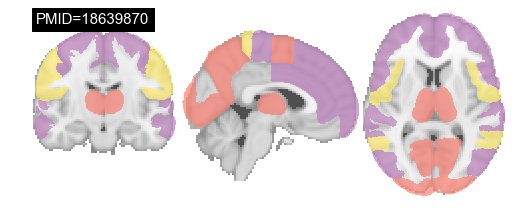

TP=Purple, FP=Yellow, FN=Red


In [31]:
display = plotting.plot_stat_map(performance_map,
                                         cmap="Set3",
                                         threshold=90,
                                         alpha=0.7,
                                         cut_coords=(4,-16,9),
                                         title="PMID={}".format(PMID[0]),
                                         annotate=False,
                                         draw_cross=False,
                                         colorbar=False)
plotting.show()
display.close()
print("TP=Purple, FP=Yellow, FN=Red")